# Calculate and save footprints over entire period.

* ## Intersect with a map of the basin 

* ### Query given footprints and calculate contours

In [91]:
%matplotlib notebook
import sys
import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, shape
import rasterio
from rasterio import features
from rasterio.transform import from_origin
from matplotlib import pyplot as plt
from geopandas import GeoDataFrame
from datetime import datetime
import datetime
from rasterio.plot import show
import Footprint_Processing as FP
import importlib

DateRange=['2016-6-23 12:00:00','2016-8-23 23:30:00']  ## Subset for testing
Axis = 40
rs = [50,75,90]
dx = 1
XY = [516095.94,7707929.74] ## From the Map
# XY = [516098.07,7707934.37] ## From Eddypro GPS
nx = 1000
fp_params={'dx':dx,'nx':nx,'rs':rs}
west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2

thres=.05

RasterPath = 'C:/Illisarvik/Footprints/'
DataName = 'C:/Illisarvik/FilteredData2019-02-15.csv'


<IPython.core.display.Javascript object>


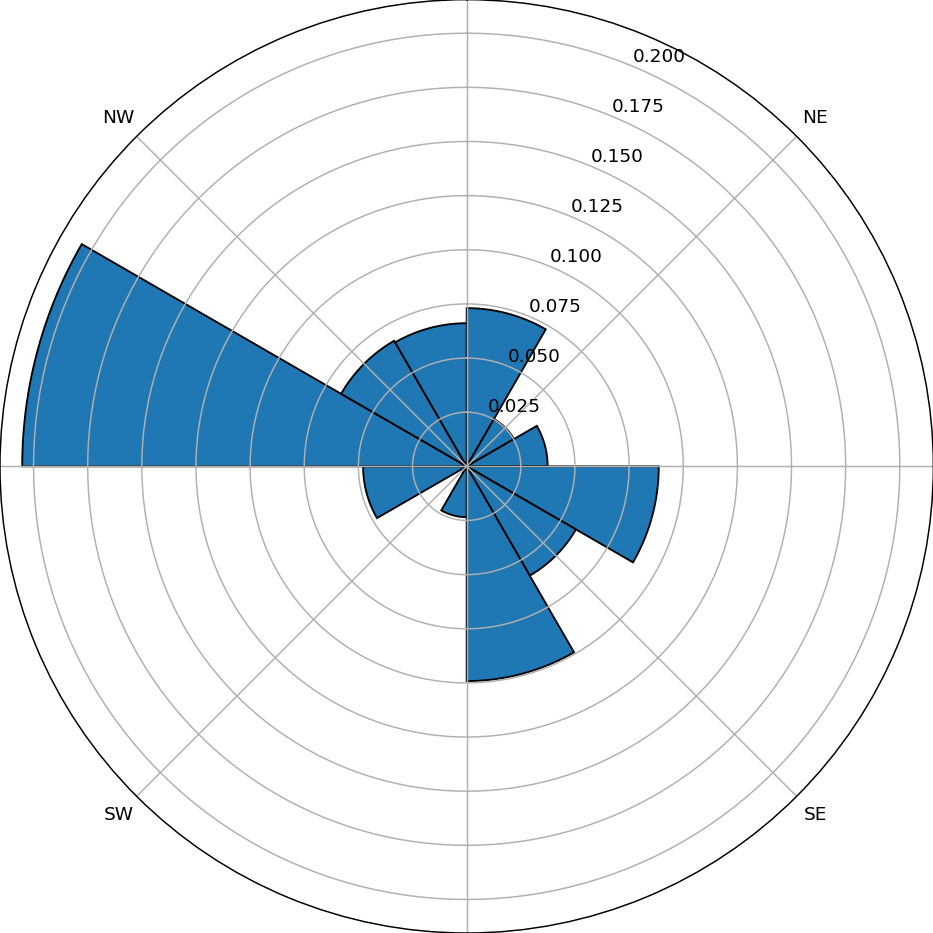

0.7913043478260869
datetime
2016-07-10 18:30:00    23.494000
2016-07-10 19:00:00    23.015000
2016-07-10 19:30:00    22.193333
2016-07-10 20:00:00    21.655000
2016-07-10 20:30:00    20.821667
2016-07-10 21:00:00    19.695000
2016-07-10 21:30:00    18.960000
2016-07-10 22:00:00    18.071667
2016-07-10 22:30:00    17.691667
2016-07-10 23:00:00    17.108333
2016-07-10 23:30:00    16.906667
2016-07-11 00:00:00    17.520000
2016-07-11 00:30:00    17.310000
2016-07-11 01:00:00    17.216667
2016-07-11 01:30:00    17.156667
2016-07-11 02:00:00    17.113333
2016-07-11 02:30:00    17.068333
2016-07-11 03:00:00    17.033333
2016-07-11 03:30:00    17.256667
2016-07-11 04:00:00    17.023333
2016-07-11 04:30:00    17.225000
2016-07-11 05:00:00    17.585000
2016-07-11 05:30:00    16.835000
2016-07-11 06:00:00    15.490000
2016-07-11 06:30:00    15.160000
2016-07-11 07:00:00    15.041667
2016-07-11 07:30:00    14.788333
2016-07-11 08:00:00    14.448333
2016-07-11 08:30:00    13.961667
2016-07-11 09:0

<IPython.core.display.Javascript object>


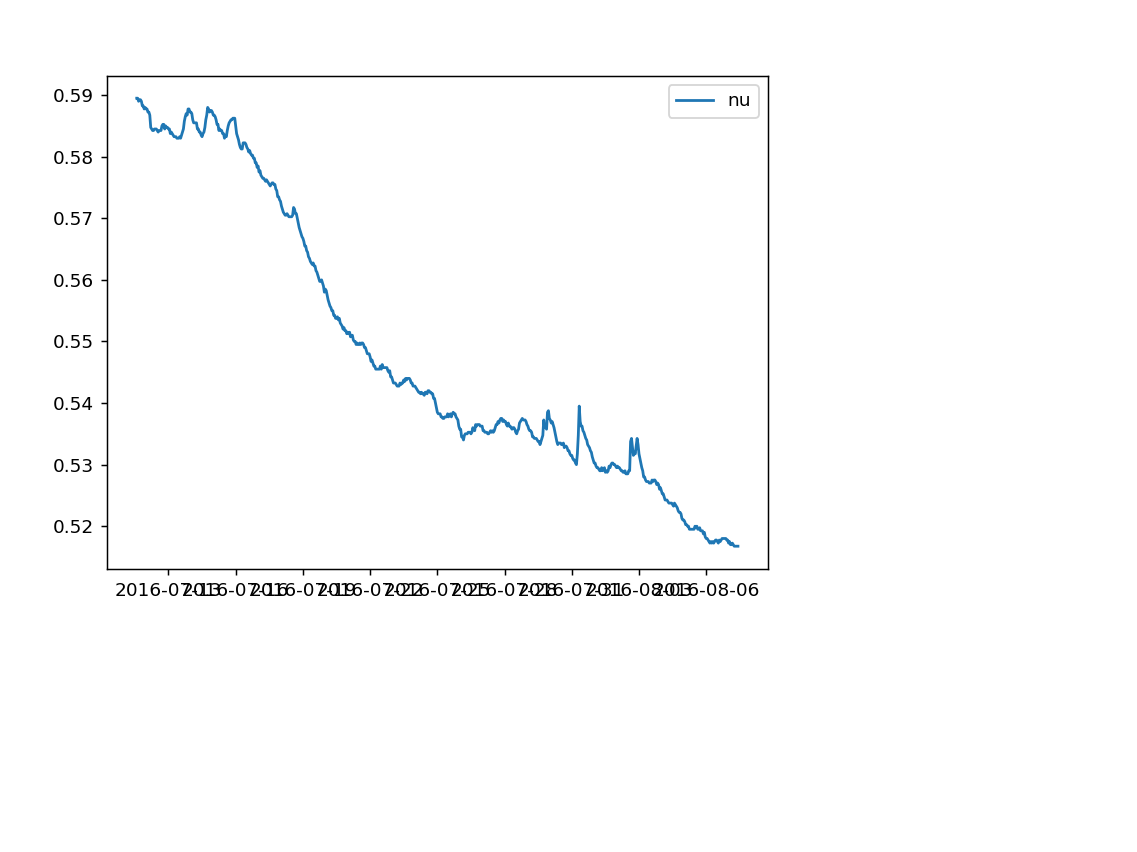

In [92]:

Filter = 30
Data = pd.read_csv(DataName)
Data = Data.set_index(pd.DatetimeIndex(Data.datetime))
Data['Run']=np.nan
Data.loc[(np.isfinite(Data['wind_dir'])==True)&(Data['u*']>.1)&
         (Data.index>DateRange[0])&(Data.index<DateRange[1])&              # Run a subset for teting
         ((Data['wind_dir']<Axis+180-Filter)|(Data['wind_dir']>Axis+180+Filter))&
         ((Data['wind_dir']<Axis+180-Filter)|(Data['wind_dir']>Axis)),
         ['Run']]=1

Data['Zo']=Data['canopy_height'] * .10
Data['d']=Data['canopy_height'].mean()*.66
Data['Z_L'] = Data['Zm']/Data['L']


# f = plt.figure(figsize = (10,8))
f = plt.figure(figsize = (7,7))
# ax = f.add_axes([0.05, 0.6, .9, 0.35]) # Left, Bottom, Width, Height
# ax2 = f.add_axes([0.0, 0, 1, .55], polar=True)
ax2 = f.add_axes([0.0, 0, 1, 1], polar=True)


# ax.plot(Data['Zo'],label = 'Measurement Based')


Data['Zm']=Data['Zm']-Data['d']
Data['Z_L'] = Data['Zm']/Data['L']
Data['Z0'] = Data['Zm']*np.exp(-.41*Data['wind_speed']/Data['u*'])

Data.loc[(Data['Z_L']<-thres)|(Data['Z_L']>thres),['Z0']]=np.nan




TempData = Data[np.isfinite(Data['Run'])]
Total_Obs = TempData['Run'].count()
Var = 'fch4'

Wind_Groups_median = TempData.groupby(['Dir']).median()
Wind_Groups_std = TempData.groupby(['Dir']).std()
Wind_Groups_Ct = TempData.groupby(['Dir']).count()
Wind_Groups_CI = Wind_Groups_std/Wind_Groups_Ct**.5*1.96

Wind_Groups_median['Dir'] = Wind_Groups_median.index*np.pi/180

# ax.plot(Data['Z0'],label='D = Ch *.66')


# ax.grid()
# ax.set_ylim(0,.1)


Wind_Groups_median['Pos'] = Wind_Groups_median[Var]*1
Wind_Groups_median['Neg'] = Wind_Groups_median[Var]*1

Wind_Groups_median.loc[Wind_Groups_median[Var]<0,'Pos']*=0
Wind_Groups_median.loc[Wind_Groups_median[Var]>0,'Neg']*=0
Wind_Groups_median.loc[Wind_Groups_median[Var]<0,'Neg']*=-1



# Counts
ax2.bar(Wind_Groups_median['Dir'],Wind_Groups_Ct[Var].values/Total_Obs,edgecolor='black',width = 30*np.pi/180)
print(Wind_Groups_Ct[Var].sum()/Total_Obs)


ax2.set_theta_direction(-1)
ax2.set_theta_offset(0)
ax2.set_theta_zero_location('N')
ax2.set_thetagrids([0,45,90,135,180,225,270,315],['N','NE','E','SE','S','SW','W','NW'])

for d in Wind_Groups_median.index:
    Data.loc[Data['Dir']==d,'Zo']=Wind_Groups_median.loc[d]['Z0']
Data['Zo'] = Data['Zo'].fillna(100)
print(Data[10:60]['AirTC_Avg'])
# ax.plot(Data['Zo'])

fig = plt.figure()
# print(Data['VWC'])
Data.loc[Data['VWC']<.4,'VWC']=np.nan
Data['VWC'] = Data['VWC'].interpolate('linear')
plt.plot(Data['VWC'],label='nu')
plt.legend()

# print(Data['PBLH'])

# Date Range & Paramters
## Read & filter the data, initialize the Basin Map

<IPython.core.display.Javascript object>


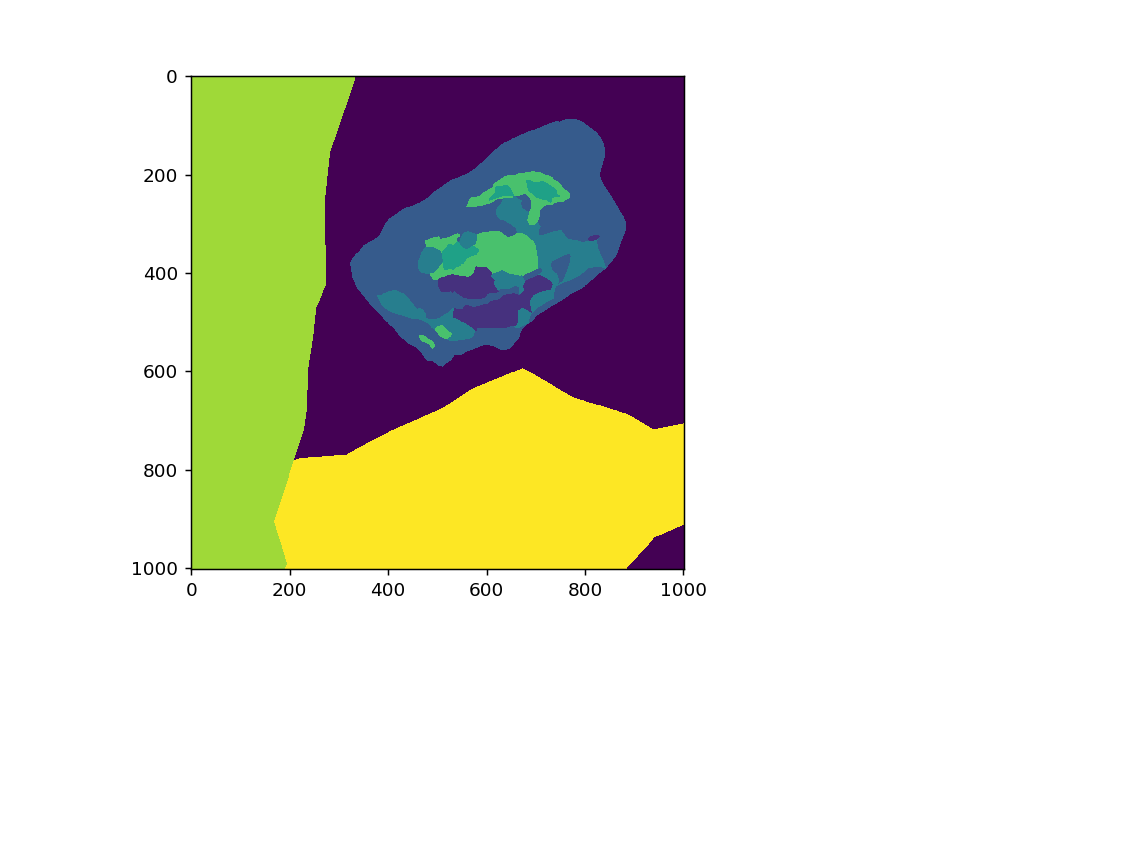

In [93]:


# Data=Data.reset_index(drop=True)
# Dates = Data['datetime']
# Run = Data.loc[Data['Run']==1].reset_index().drop(['index'],axis=1)
# Runs = Run.shape[0]
# Temp = Data.copy()
# print(Data['datetime'].iloc[3])

Basin = gpd.read_file('C:\\Illisarvik\\Mapping/Vegetation_Skeeter_3.0.shp')
Basin['Area'] = Basin.area
# Basin['Unit'] = Basin['Code'].astype(float)


Code = 'Code'
Name = 'Class'
Basin[Code] = Basin[Code].astype(float)


shapes = ((geom,value) for geom,value in zip(Basin['geometry'],Basin[Code]))
west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2
Transform = from_origin(west,north,dx,dx)

plt.figure()
with rasterio.open('Basin_Image.tif','w',driver='GTiff',width = nx+1, height = nx+1,count = 1,dtype=np.float64,
                   affine = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    out_arr = out.read(1)
    params = out.profile
    del params['transform']
    Basin_Image = features.rasterize(shapes=shapes,fill = 100,out = out_arr,transform = out.affine,default_value=0)
    out.write(Basin_Image,1)
    show((out))
# print(Basin[Code])

## Footprints

[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%


<IPython.core.display.Javascript object>


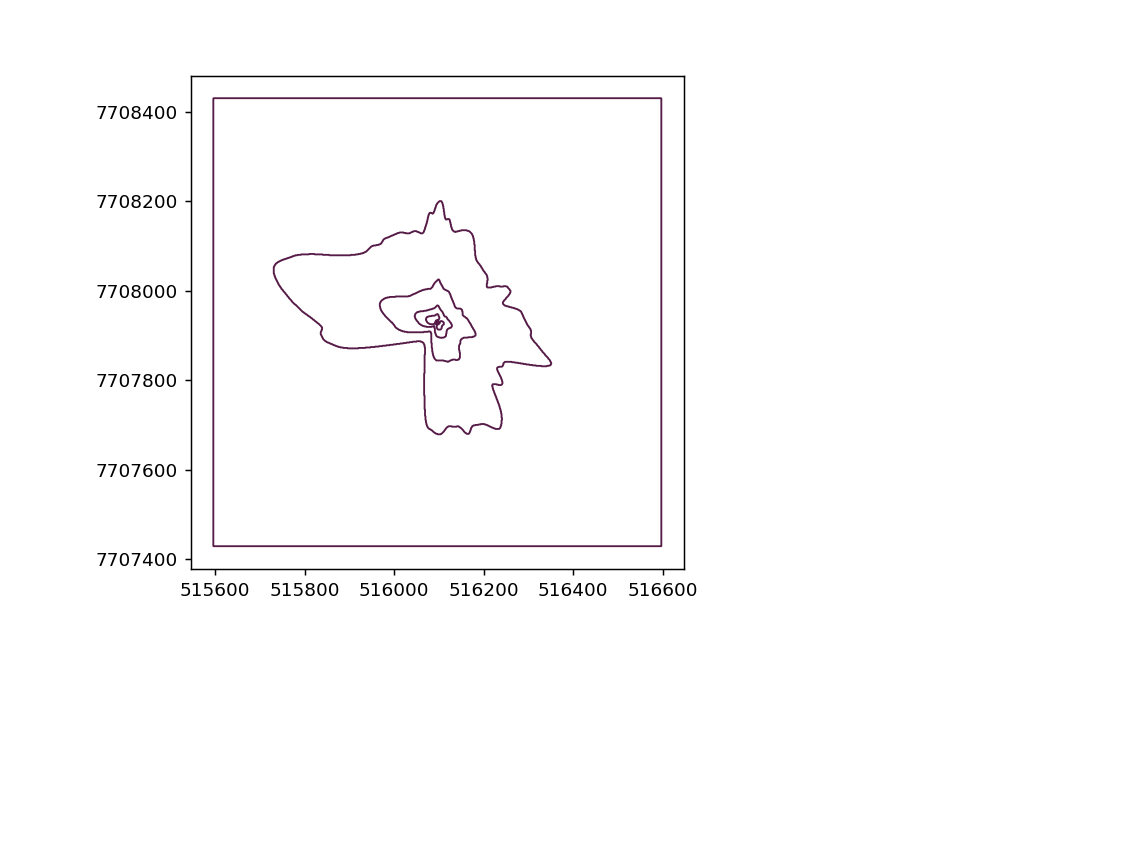

In [94]:
# plt.figure()
Go = True
if Go == True:
    importlib.reload(FP)
    FP_Data = FP.Calculate(RasterPath,Data,os.getcwd()+'/Basin_Image.tif',XY,Classes=Basin,
                          Name='Class',Code='Code',nx=nx,dx=dx)
#     print(FP_Data.Intersections)
#     Data = Data.merge(FP_Data.Intersections,left_on='datetime',right_on='datetime', how='outer')
    
    FP_Data.Data['Out_of_Basin'] = FP_Data.Data['Upland']+FP_Data.Data['Ocean']+FP_Data.Data['Fen']+(1-Data['Sum'])
    FP_Data.Data.to_csv('Data_Footprints_'+str(datetime.datetime.now()).split(' ')[0]+'.csv')


## Query Footprints

In [77]:
# FP2 = FP_Data.reset_index
print(Data[10:60]['AirTC_Avg'])
print(FP_Data.Data[10:60]['AirTC_Avg'])


# FP2 = FP_Data.Intersections.set_index(pd.DatetimeIndex(FP_Data.Intersections.datetime))
# # print(Fp2[10:60])
# # Data = Data.merge(FP_Data.Intersections,left_on='datetime',right_on='datetime', how='outer')

# # Data['Out_of_Basin'] = Data['Upland']+Data['Ocean']+Data['Fen']+(1-Data['Sum'])

# # Data.to_csv('Data_Footprints_'+str(datetime.datetime.now()).split(' ')[0]+'.csv')

# # plt.colorbar()
# Data2 = Temp.merge(Run,left_on='datetime',right_on='datetime', how='outer')
# print(Run)
# Data2.to_csv('temp.csv')
# Data3 = Data.copy()

datetime
2016-07-10 21:30:00    23.494000
2016-07-10 22:00:00    23.015000
2016-07-10 22:30:00    22.193333
2016-07-10 23:00:00    21.655000
2016-07-10 23:30:00    20.821667
2016-07-11 00:00:00    19.695000
2016-07-11 00:30:00    18.960000
2016-07-11 01:00:00    18.071667
2016-07-11 01:30:00    17.691667
2016-07-11 02:00:00    17.108333
2016-07-11 02:30:00    16.906667
2016-07-11 03:00:00    17.520000
2016-07-11 03:30:00    17.310000
2016-07-11 04:00:00    17.216667
2016-07-11 04:30:00    17.156667
2016-07-11 05:00:00    17.113333
2016-07-11 05:30:00    17.068333
2016-07-11 06:00:00    17.033333
2016-07-11 06:30:00    17.256667
2016-07-11 07:00:00    17.023333
2016-07-11 07:30:00    17.225000
2016-07-11 08:00:00    17.585000
2016-07-11 08:30:00    16.835000
2016-07-11 09:00:00    15.490000
2016-07-11 09:30:00    15.160000
2016-07-11 10:00:00    15.041667
2016-07-11 10:30:00    14.788333
2016-07-11 11:00:00    14.448333
2016-07-11 11:30:00    13.961667
2016-07-11 12:00:00    13.518333
2

In [23]:
# print(Run['Sedge'].mean())

Run = pd.read_csv('C:\\Users\\wesle\\NetworkAnalysis\\Illisarvik/ECData.csv')
# print(Run)

Jobs = {}


# Q = Run['fch4'].quantile(1)
index = Run.loc[(Run['Sedge']<=.18)&(Run['Sedge']>=.08)].datetime
Jobs['SmallSedge'] = index

index = Run.loc[(Run['fch4']>=.03)&(Run['Sedge']>=.4)].datetime
Jobs['BigSedgeHigh'] = index

index = Run.loc[(Run['fch4']<=.02)&(Run['Sedge']>=.4)].datetime
Jobs['BigSedgeLow'] = index

# plt.figure()
# plt.scatter(Run['fch4'],Run['Sedge'])

# Q = Run['fch4'].quantile(1)
# index = Run.loc[Run['fch4']<=Q].datetime
# Jobs['CH4'] = index

# print(index.shape)

# Q = Run['fco2'].quantile(1)
# index = Run.loc[Run['fco2']<Q].datetime
# Jobs['CO2'] = index


# Query=[['2016-7-23 15:30:00','2016-7-23 19:00:00','Test1']]#,
# #       ['2016-7-23 12:30:00','2016-7-23 13:30:00','Test2']]
# for query in Query:
#     index = pd.date_range((query[0]),(query[1]),freq='30T')
#     Jobs[query[2]]=index
    
print(Jobs)
# fig,ax=plt.subplots(1,1,figsize = (5,5))
# with rasterio.open('C:/Illisarvik/odm_orthophoto_modified_Translate.tif','r') as Im:
# #     print(Im.read())
#     show((Im))
Cont = FP.Contours(RasterPath,Jobs=Jobs,ax=ax,r=[.25,.5,.8,.9])
# ax.legend()
# ax.set_xlim(XY[1]-150,XY[1]+150)
# ax.set_ylim(XY[0]-150,XY[0]+150)

{'SmallSedge': 122     2016-07-13 05:30:00
124     2016-07-13 06:30:00
148     2016-07-13 18:30:00
756     2016-07-26 10:30:00
757     2016-07-26 11:00:00
759     2016-07-26 12:00:00
760     2016-07-26 12:30:00
761     2016-07-26 13:00:00
762     2016-07-26 13:30:00
763     2016-07-26 14:00:00
764     2016-07-26 14:30:00
765     2016-07-26 15:00:00
785     2016-07-27 01:00:00
786     2016-07-27 01:30:00
1286    2016-08-06 11:30:00
1287    2016-08-06 12:00:00
1288    2016-08-06 12:30:00
1289    2016-08-06 13:00:00
1291    2016-08-06 14:00:00
1292    2016-08-06 14:30:00
1293    2016-08-06 15:00:00
1294    2016-08-06 15:30:00
1295    2016-08-06 16:00:00
1296    2016-08-06 16:30:00
1297    2016-08-06 17:00:00
1298    2016-08-06 17:30:00
1300    2016-08-06 18:30:00
1301    2016-08-06 19:00:00
1302    2016-08-06 19:30:00
1303    2016-08-06 20:00:00
1312    2016-08-07 00:30:00
1324    2016-08-07 06:30:00
1326    2016-08-07 07:30:00
1329    2016-08-07 09:00:00
1332    2016-08-07 10:30:00
1334 